# Demo


The purpose of this notebook is to create a minimum working example of seaglider data in OG1 format. The test case is to convert sg015 data from the Labrador Sea in September 2004.

- OG1 format is a newly agreed format (since June 2024) for glider data sets from various platforms (e.g., Seaglider, Slocum, Seaexplorer).  It lives on github here: (https://github.com/OceanGlidersCommunity/OG-format-user-manual).
- OG1 manual: https://oceangliderscommunity.github.io/OG-format-user-manual/OG_Format.html


In [ ]:
import sys
import importlib
sys.path.append('/Users/eddifying/Cloudfree/gitlab-cloudfree/seagliderOG1')


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from seagliderOG1 import fetchers
from seagliderOG1 import tools
from seagliderOG1 import plotters
import xarray as xr
import os


## Load Seaglider data in native format

This has three ways to load a glider dataset.

Load an example dataset using `seagliderOG1.fetchers.load_sample_dataset`

Alternatively, use your own with e.g. `ds = xr.open_dataset('/path/to/yourfile.nc')`

### Load a sample dataset

These data are hosted (currently) on dropbox.

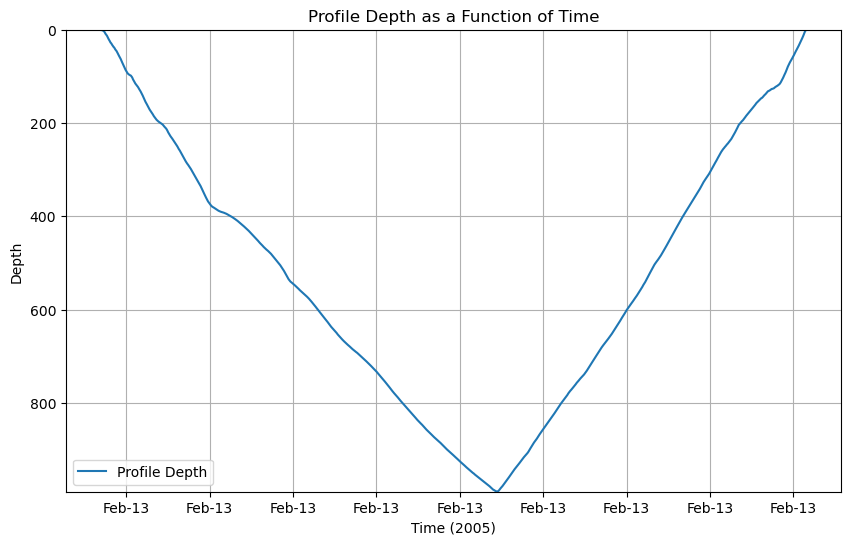

In [3]:
# List of available datasets
file_list = ['p0150500_20050213.nc', 'p0150501_20050213.nc', 'p0150502_20050214.nc', 'p0150503_20050214.nc', 'p0150504_20050215.nc'];

# Loads one dataset (p0150500_20050213.nc)
ds = fetchers.load_sample_dataset()
plotters.plot_profile_depth(ds)

### Load dataset from local machine

- For local data in the directory `input_dir`
- Creates a plot of ctd_depth against ctd_time.


/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


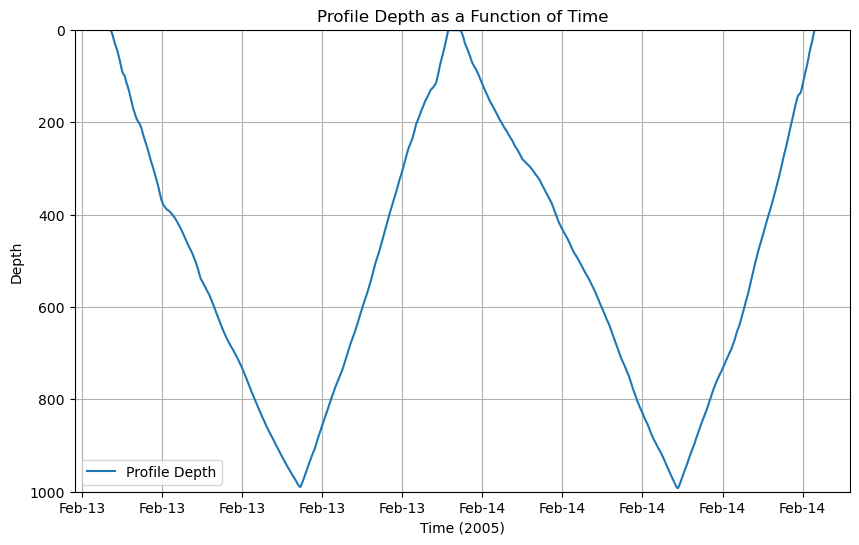

In [4]:
# Specify the input directory on your local machine
input_dir = "/Users/eddifying/Dropbox/data/sg015-ncei-download"

# Load and concatenate all datasets in the input directory
# Optionally, specify the range of profiles to load (start_profile, end_profile)
ds_all = fetchers.load_dataset_from_directory(input_dir, start_profile=500, end_profile=501)

# Simple plot of depth against time
plotters.plot_profile_depth(ds_all)

### Load data from the NCEI server

- Data from the sg015 mission in the Labrador Sea (https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0111844), dataset identifier gov.noaa.nodc:0111844.


/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


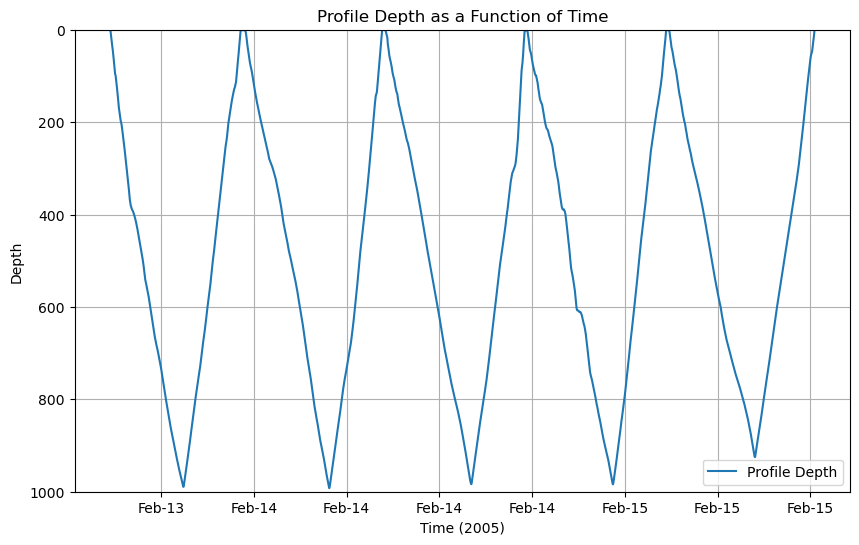

In [5]:
# Specify the server where data are located
server = "https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/015/20040924/"

# This was necessary to get an initial file list
# mylist = fetchers.list_files_in_https_server(server)
# fetchers.create_pooch_registry_from_directory("/Users/eddifying/Dropbox/data/sg015-ncei-download/")

# Load and concatenate all datasets from the server, optionally specifying the range of profiles to load
ds_all = fetchers.load_dataset_from_online(server, start_profile=500, end_profile=504)

# Simple plot of depth against time
plotters.plot_profile_depth(ds_all)

## Start to think about renaming variables

### Check what variables are in the file

- Here, I found it easier to use glidertools (https://glidertools.readthedocs.io/en/latest/loading.html#working-with-seaglider-base-station-files) to get a quick look at what's in there.

In [14]:
# Print the variables from one file
filenames = input_dir + "/" + file_list[0]
print(filenames)

plotters.show_variables(filenames)


/Users/eddifying/Dropbox/data/sg015-ncei-download/p0150500_20050213.nc
information is based on file: /Users/eddifying/Dropbox/data/sg015-ncei-download/p0150500_20050213.nc


,dims,units,comment
name,,,
gc_data_pts,gc_event,1,
gc_depth,gc_event,meters,
gc_end_secs,gc_event,seconds since 1970-1-1 00:00:00,End of GC time in GMT epoch format
gc_gcphase,gc_event,,
gc_ob_vertv,gc_event,cm/s,
gc_pitch_ctl,gc_event,cm,
gc_pitch_secs,gc_event,seconds,Elapsed seconds since start of this pitch change
gc_roll_secs,gc_event,seconds,Elapsed seconds since start of this roll change
gc_st_secs,gc_event,seconds since 1970-1-1 00:00:00,Start of GC time in GMT epoch format


### Check the attributes in the basestation file

There was no equivalent in glidertools, so I wrote one and put it in `seagliderOG1.plotters`

In [15]:
file_list = ['p0150500_20050213.nc', 'p0150501_20050213.nc', 'p0150502_20050214.nc', 'p0150503_20050214.nc', 'p0150504_20050215.nc'];
filenames = input_dir + "/" + file_list[0]
plotters.show_attributes(filenames)

information is based on file: /Users/eddifying/Dropbox/data/sg015-ncei-download/p0150500_20050213.nc


,Attribute,Value
0,quality_control_version,1.1
1,base_station_micro_version,3705
2,time_coverage_resolution,PT1S
3,geospatial_vertical_max,989.698459
4,sea_name,Labrador Sea
5,mission,1
6,geospatial_lat_units,degrees
7,geospatial_lon_units,degrees
8,references,"Frajka-Williams, E.F. and P.B.Rhines 2009: Phy..."
9,seaglider_software_version,66.050003


### Assign new attributes

Some of the attributes in the basestation netcdf file can be translated fairly easily into the OG1 format.  This is done in `tools.modify_attributes`.  At present, the "extra" attributes are retained at the bottom of the list.


In [ ]:
# Specify the input directory on your local machine
input_dir = "/Users/eddifying/Dropbox/data/sg015-ncei-download"

# Load and concatenate all datasets in the input directory
# Optionally, specify the range of profiles to load (start_profile, end_profile)
ds_all = fetchers.load_dataset_from_directory(input_dir, start_profile=500, end_profile=501)

# Generate the dictionaries and lists to change the attributes
attr_to_add, attr_as_is, attr_to_change, attr_to_remove = tools.generate_attributes(ds_all)

# Assign new values to the attributes
ds_all = tools.modify_attributes(ds_all, attr_to_add, attr_as_is, attr_to_change, attr_to_remove)


### Rename variables

In [ ]:
# Define dictionaries for renaming
#ds_single = xr.open_dataset(file_list[0])

dims_rename_dict = {'sg_data_point': 'N_MEASUREMENTS'}
coords_rename_dict = {
    'longitude': 'LONGITUDE',
    'latitude': 'LATITUDE',
    'ctd_time': 'TIME',
    'ctd_depth': 'DEPTH'
}
vars_rename_dict = {
    'conductivity': 'CNDC',
    'temperature': 'TEMP',
    'salinity': 'PSAL', # after thermal lag correction
#    'conductivity_qc': 'CNDC_QC',
#    'salinity_qc': 'PSAL_QC',
#    'temperature_qc': 'TEMP_QC',
    'vert_speed': 'VERT_GLIDER_SPEED', # This is using the hdm
    'horz_speed': 'HORZ_GLIDER_SPEED', # This is using the hdm
    'density': 'DENSITY',
}

def create_renamed_dataset(ds, dims_rename_dict, coords_rename_dict, vars_rename_dict):
    # Apply renaming using the dictionaries
    ds_renamed = ds.rename_dims(dims_rename_dict)
    ds_renamed = ds_renamed.rename_vars(coords_rename_dict)
    ds_renamed = ds_renamed.rename_vars(vars_rename_dict)
    
    # Remove variables not in vars_rename_dict().values
    vars_to_keep = set(vars_rename_dict.values())
    ds_renamed = ds_renamed[vars_to_keep]
    return ds_renamed

# Example usage
ds_renamed = create_renamed_dataset(ds_new_att, dims_rename_dict, coords_rename_dict, vars_rename_dict)
print(ds_renamed)

## Check the final dataset

At the moment, since the plotters.show_attributes() and plotters.show_variables() are designed to work with netcdf files, I write the xarray dataset to netcdf before loading it and checking the attributes and variable names.

In [ ]:

## Save the dataset to a NetCDF file
# Check if the file exists and delete it if it does
output_file = os.path.join('../data', 'test.nc')
if os.path.exists(output_file):
    os.remove(output_file)

# Save the dataset to a NetCDF file
ds_renamed.to_netcdf(output_file, mode='w', format='NETCDF4_CLASSIC')

# Show the attributes of the saved NetCDF file
plotters.show_attributes(output_file)


In [ ]:
def plot_speeds(ds):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot horizontal speed
    ax[0].plot(ds['ctd_time'], ds['horz_speed'], label='Horizontal Speed', color='b')
    ax[0].set_ylabel('Horizontal Speed (m/s)')
    ax[0].legend()
    ax[0].grid(True)

    # Plot vertical speed
    ax[1].plot(ds['ctd_time'], ds['vert_speed'], label='Vertical Speed', color='r')
    ax[1].set_ylabel('Vertical Speed (m/s)')
    ax[1].set_xlabel('Time')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_speeds(ds_all)